In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import coremltools
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from keras.utils import np_utils
import sklearn

import pickle
import os

In [2]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')


In [3]:
# The number of steps within one time segment
TIME_PERIODS = 100
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 100

In [4]:
#Load the data

#kv_c_filename = "MouvementData-V1-Courir-Ratti.csv"
#ax_c_filename = "MouvementData-V2-Courir-Axel.csv"
#ag_c_filename = "MouvementData-V3-Courir-Agigi.csv"
#la_c_filename = "MouvementData-V4-Courir-Lavy.csv"
#kv_m_filename = "MouvementData-V1-Marche-Ratti.csv"
#ax_m_filename = "MouvementData-V4-Marcher-Axel.csv"
#ag_m_filename = "MouvementData-V3-Marcher-Agigi.csv"
#la_m_filename = "MouvementData-V2-Marcher-Lavy.csv"
#kv_i_filename = "MouvementData-V1-Immobile-Ratti.csv"
#kv_m2_filename = "MouvementData-V5-Marcher-Ratti.csv"
#kv_c2_filename = "MouvementData-V5-Courir-Ratti.csv"

#files = {ax_c_filename, ag_c_filename, la_c_filename, kv_m_filename, ax_m_filename, ag_m_filename, la_m_filename, kv_i_filename, kv_m2_filename,kv_c2_filename }
#pd.read_csv(kv_c_filename, delimiter=",")

data = pd.DataFrame(columns=['userId','dX-acc','dY-acc','dZ-acc','dX-gyr','dY-gyr','dZ-gyr','time','activityType'])
files = os.listdir('TrainingData/')

for f in files:
    newData = pd.read_csv('TrainingData/'+f, delimiter=",")
    newData = newData[newData.time >= 100]
    newData = newData[newData.time <= (newData['time'].max() - 300)]
    data = data.append(newData,False,False,False)

data

,userId,dX-acc,dY-acc,dZ-acc,dX-gyr,dY-gyr,dZ-gyr,time,activityType
0,2,0.0,0.0,0.0,-0.8,-0.2,0.3,346.0,Immobile
1,2,3.3,5.5,7.4,-0.8,-0.2,0.3,366.0,Immobile
2,2,3.3,5.5,7.4,0.6,0.2,0.3,526.0,Immobile
3,2,3.3,5.5,7.4,0.6,0.2,0.3,568.0,Immobile
4,2,3.3,5.5,7.4,0.6,0.2,0.3,569.0,Immobile
...,...,...,...,...,...,...,...,...,...
5918,1,-3.4,9.1,-1.0,-0.0,0.1,-0.1,106927.0,Marcher
5919,1,-3.4,9.0,-0.6,-0.0,0.1,-0.1,106928.0,Marcher
5920,1,-3.2,9.2,-0.6,-0.0,0.1,-0.1,106929.0,Marcher
5921,1,-3.1,9.2,-0.8,-0.0,0.1,-0.1,106930.0,Marcher


In [5]:
LABELS = data["activityType"].unique()
LABELS

array(['Immobile', 'Marcher', 'Descendre', 'Monter', 'Courir'],
      dtype=object)

In [6]:
def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

In [7]:
#Make sure all values are float typed
data["dX-acc"] = data["dX-acc"].apply(convert_to_float)
data["dY-acc"] = data["dY-acc"].apply(convert_to_float)
data["dZ-acc"] = data["dZ-acc"].apply(convert_to_float)
data["dX-gyr"] = data["dX-gyr"].apply(convert_to_float)
data["dY-gyr"] = data["dY-gyr"].apply(convert_to_float)
data["dZ-gyr"] = data["dZ-gyr"].apply(convert_to_float)

In [8]:
#Show data information
print('Number of columns in the dataframe: %i' % (data.shape[1]))
print('Number of rows in the dataframe: %i\n' % (data.shape[0]))

Number of columns in the dataframe: 9
Number of rows in the dataframe: 179397



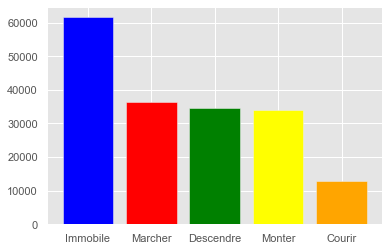

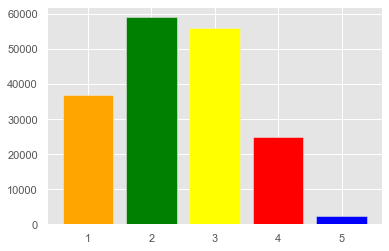

In [9]:
# Show how many training examples exist for each activity
plt.bar(LABELS, data['activityType'].value_counts(), color=['blue', 'red', 'green', 'yellow', 'orange'])
plt.plot(kind='bar',title='Training Examples by Activity Type')
plt.show()
# Show how many training examples exist for each user
USERS = data["userId"].unique()
plt.bar(USERS, data['userId'].value_counts(), color=['green', 'yellow', 'orange', 'red', 'blue'])
plt.plot(kind='bar', title='Training Examples by User')
plt.show()

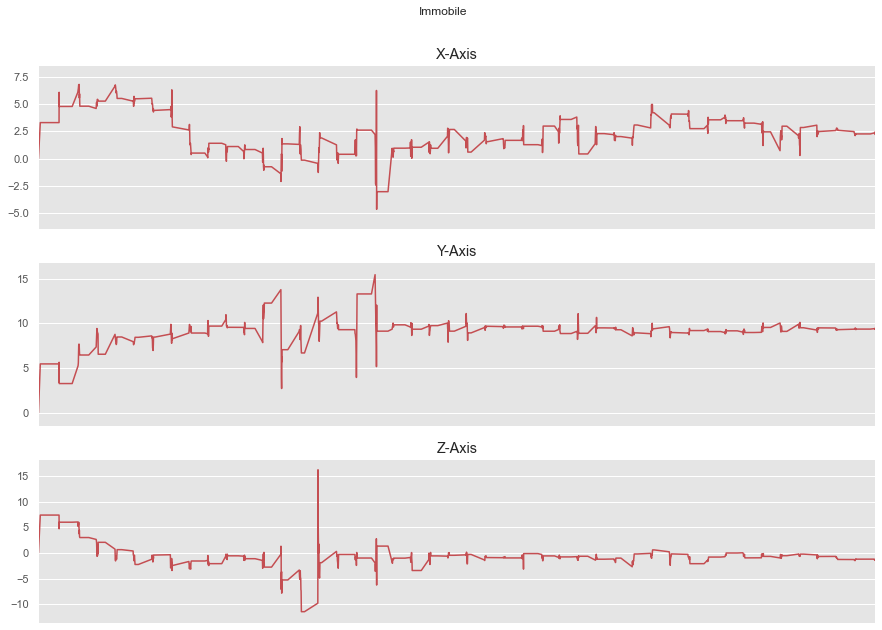

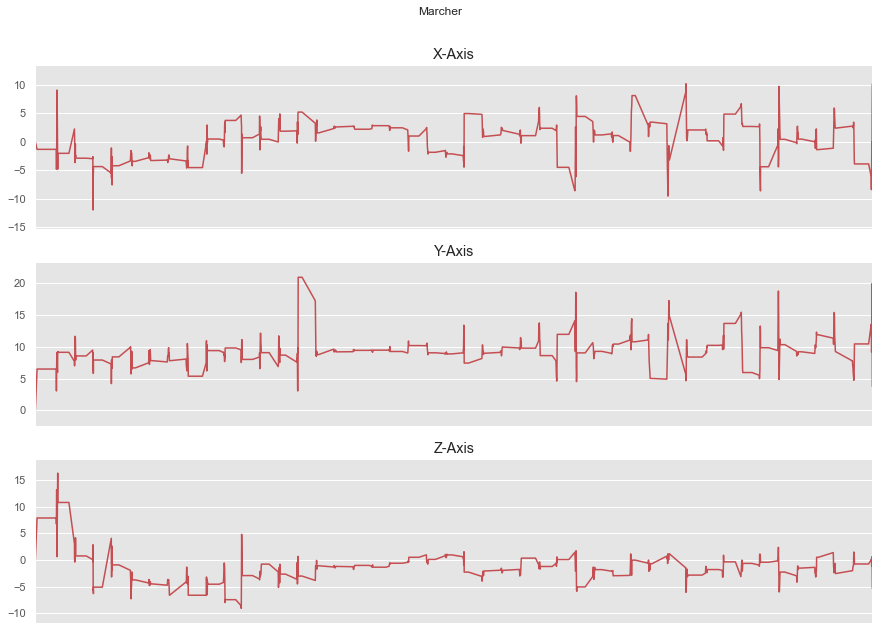

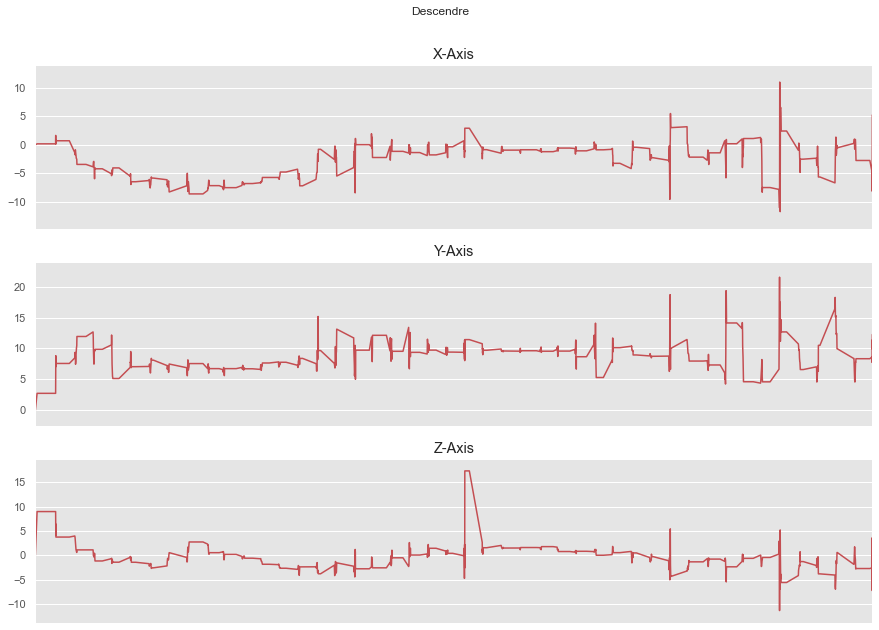

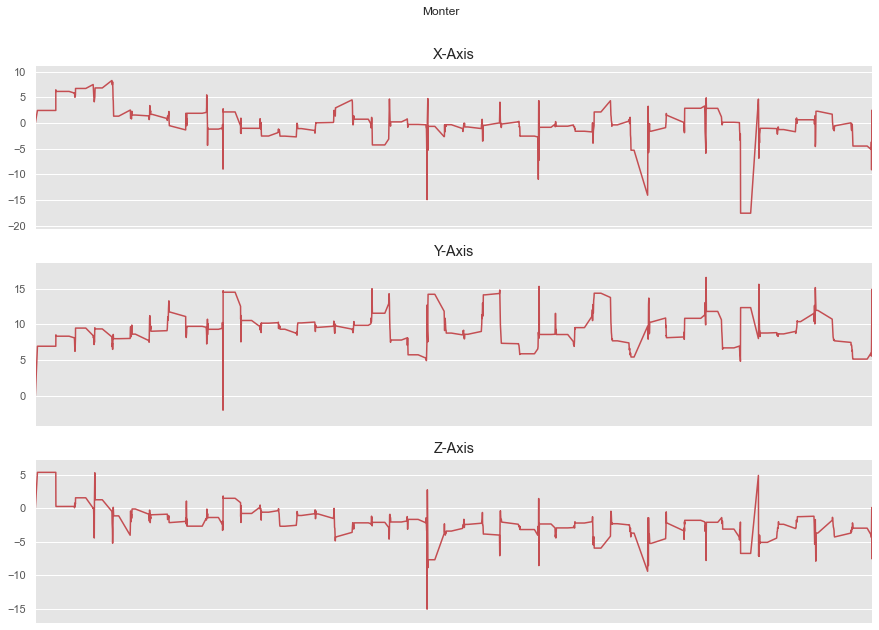

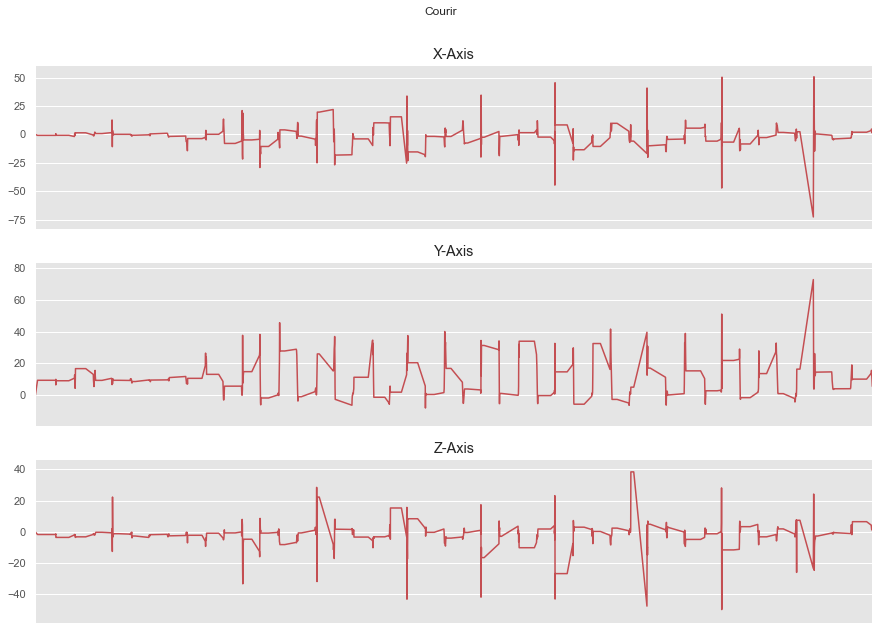

In [10]:
# Sampling frequency = 100Hz

def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['time'], data['dX-acc'], 'X-Axis')
    plot_axis(ax1, data['time'], data['dY-acc'], 'Y-Axis')
    plot_axis(ax2, data['time'], data['dZ-acc'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
for activity in LABELS:
    #plot the first five seconds (we have a sample every 10ms then 100 per second)
    subset = data[data['activityType'] == activity][:500] 
    plot_activity(activity, subset)

In [11]:
#Transform the labels into numeric values

# Define column name of the label vector
LABEL = 'Numeric activity type'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
data[LABEL] = le.fit_transform(data['activityType'].values.ravel())
print(data['activityType'].unique())
data[LABEL].unique()

['Immobile' 'Marcher' 'Descendre' 'Monter' 'Courir']


array([2, 3, 1, 4, 0], dtype=int64)

In [12]:
#Split the data using users ID's
#TODO: first, we only have one user Immobile data -> produce another  immobile data
trainingData = data[data["userId"] <= 3]

testData = data[data["userId"] > 3]
#TODO: This will duplicate Immobile data: correct it by adding other Immobile users data
testData = testData.append(data[data["activityType"] == "Immobile"],False,False,False)

In [13]:
#Reshape data into segments and prepare for Keras

def create_segments_and_labels(df, time_steps, step, label_name):

    # dXacc, dYacc, dZacc, dXgyr, dYgyr, dZgyr as features
    N_FEATURES = 6
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        dXaccs = df['dX-acc'].values[i: i + time_steps]
        dYaccs = df['dY-acc'].values[i: i + time_steps]
        dZaccs = df['dZ-acc'].values[i: i + time_steps]
        dXgyrs = df['dX-gyr'].values[i: i + time_steps]
        dYgyrs = df['dY-gyr'].values[i: i + time_steps]
        dZgyrs = df['dZ-gyr'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([dXaccs, dYaccs, dZaccs, dXgyrs, dYgyrs, dZgyrs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [14]:
#Data transformation

def transform_data(data):
    #Normalize training data
    # Normalize features for training data set (values between 0 and 1)
    # Surpress warning for next 3 operation
    pd.options.mode.chained_assignment = None  # default='warn'

    data['dX-acc'] = data['dX-acc'] / data['dX-acc'].max()
    data['dY-acc'] = data['dY-acc'] / data['dY-acc'].max()
    data['dZ-acc'] = data['dZ-acc'] / data['dZ-acc'].max()
    data['dX-gyr'] = data['dX-gyr'] / data['dX-gyr'].max()
    data['dY-gyr'] = data['dY-gyr'] / data['dY-gyr'].max()
    data['dZ-gyr'] = data['dZ-gyr'] / data['dZ-gyr'].max()
    # Round numbers
    data = data.round({'dX-acc': 4, 'dY-acc': 4, 'dZ-acc': 4, 'dX-gyr': 4, 'dY-gyr': 4, 'dZ-gyr': 4 })
    
    x_train, y_train = create_segments_and_labels(data, TIME_PERIODS,STEP_DISTANCE,LABEL)
    
    # Set input & output dimensions
    num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
    num_classes = le.classes_.size
    
    #Flatten the data for Keras and Core ML. They are not able to deal ith matrixes
    input_shape = (num_time_periods*num_sensors)
    x_train = x_train.reshape(x_train.shape[0], input_shape)
    
    # Convert feature and label data into datatype accepted by Keras
    x_train = x_train.astype('float32')
    y_train = y_train.astype('float32')
    
    return x_train, y_train, num_time_periods, num_sensors, num_classes, input_shape

In [15]:
x_train, y_train, num_time_periods, num_sensors, num_classes, input_shape = transform_data(trainingData)

In [16]:
y_train_hot = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train_hot.shape)

New y_train shape:  (1520, 5)


In [17]:
# Create the model
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(x_train,y_train_hot)



C:\Users\fpa\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [18]:
#Prepare and transform test_data
x_test, y_test, num_time_periods, num_sensors, num_classes, input_shape = transform_data(testData)

In [19]:
y_test_hot = np_utils.to_categorical(y_test, num_classes)
print('New y_test shape: ', y_test_hot.shape)

New y_test shape:  (613, 5)


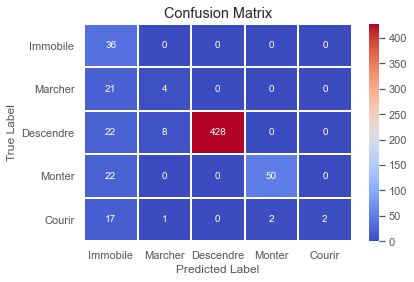

             precision    recall  f1-score   support

          0       0.31      1.00      0.47        36
          1       0.31      0.16      0.21        25
          2       1.00      0.93      0.97       458
          3       0.96      0.69      0.81        72
          4       1.00      0.09      0.17        22

avg / total       0.93      0.85      0.86       613



In [20]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_test = clf.predict(x_test)


# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test_hot, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))

In [21]:
import pickle

with open('bionless_classifier.pkl', 'wb') as f:
    pickle.dump(clf, f)